In [48]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

old_v = tf.logging.get_verbosity()
tf.logging.set_verbosity(tf.logging.ERROR)
tf.logging.set_verbosity(old_v)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## following this https://towardsdatascience.com/teaching-a-variational-autoencoder-vae-to-draw-mnist-characters-978675c95776

In [68]:
tf.reset_default_graph()
batch_size = 64

X_in = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='X')
Y    = tf.placeholder(dtype=tf.float32, shape=[None, 28, 28], name='Y')
Y_flat = tf.reshape(Y, shape=[-1, 28 * 28])
# keep_prob will be used when applying dropouts
# it'll be 0.8 during training, and 1 when we're generating new data
keep_prob = tf.placeholder(dtype=tf.float32, shape=(), name='keep_prob')

# Hyper-parameters
dec_in_channels = 1 # decode in 1 channel since it's greyscale
n_latent = 8 # number of Z variables
learning_rate_of_ADAM = 0.0005

# ??
reshaped_dim = [-1, 7, 7, dec_in_channels]
inputs_decoder = 49 * dec_in_channels / 2


def lrelu(x, alpha=0.3):
    return tf.nn.leaky_relu(features = x, alpha=alpha)

In [69]:
def encoder(X_in, keep_prob):
    activation = lrelu
    with tf.variable_scope("encoder", reuse=None): # why?
        X = tf.reshape(X_in, shape=[-1, 28, 28, 1]) #(64, 28, 28, 1)
        x = tf.layers.conv2d(X, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        print(f"conv2d: shape of x: {x.get_shape()}")
        x = tf.nn.dropout(x, keep_prob)
        print(f"dropout: shape of x: {x.get_shape()}")
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='same', activation=activation)
        print(f"conv2d: shape of x: {x.get_shape()}")
        x = tf.nn.dropout(x, keep_prob)
        print(f"dropout: shape of x: {x.get_shape()}")
        x = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=1, padding='same', activation=activation)
        print(f"conv2d: shape of x: {x.get_shape()}")
        x = tf.nn.dropout(x, keep_prob)
        print(f"dropout: shape of x: {x.get_shape()}")
        # Flattens the input while maintaining the batch_size.
        x = tf.contrib.layers.flatten(x) #(xxx, 1)
        print(f"flatten: shape of x: {x.get_shape()}")
        # for dense(), the second argument `n_latent` is the number of neurons/nodes of the layer
        mn = tf.layers.dense(x, units=n_latent) # (,8)
        print(f"dense: shape of mn: {mn.get_shape()}")
        # unit: dimention of output space
        sd  = 0.5 * tf.layers.dense(x, units=n_latent) #(,8) # why 0.5??
        print(f"dense: shape of sd: {sd.get_shape()}")
        # epsilon ~ N(0,1)
        epsilon = tf.random_normal(tf.stack([tf.shape(x)[0], n_latent]), seed = 1218)  #(xxx, 8)
        # why take e^sd instead of sd like in original function?
        z  = mn + tf.multiply(epsilon, tf.exp(sd)) # dimension of this?
        print(f"shape of epsilon: {epsilon.get_shape()}, shape of tf.exp(sd): {tf.exp(sd).get_shape()}")
        print(f"shape of z: {z.get_shape()}")
        
        return z, mn, sd

In [70]:
def decoder(sampled_z, keep_prob):
    with tf.variable_scope("decoder", reuse=None):
        x = tf.layers.dense(sampled_z, units=inputs_decoder, activation=lrelu)
        print(f"dense: shape of x: {x.get_shape()}")
        x = tf.layers.dense(x, units=inputs_decoder * 2, activation=lrelu) # why inputs_decoder * 2 + 1?
        print(f"dense: shape of x: {x.get_shape()}")
        x = tf.reshape(x, reshaped_dim)
        print(f"reshape: shape of x: {x.get_shape()}")
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=2, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        print(f"transposed conv2d: shape of x: {x.get_shape()}")
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        x = tf.nn.dropout(x, keep_prob)
        print(f"transposed conv2d: shape of x: {x.get_shape()}")
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=4, strides=1, padding='same', activation=tf.nn.relu)
        print(f"transposed conv2d: shape of x: {x.get_shape()}")
        x = tf.contrib.layers.flatten(x)
        print(f"flatten: shape of x: {x.get_shape()}")
        x = tf.layers.dense(x, units=28*28, activation=tf.nn.sigmoid)
        print(f"dense: shape of x: {x.get_shape()}")
        img = tf.reshape(x, shape=[-1, 28, 28])
        print(f"Img : {img.get_shape()}")
        return img

In [71]:
sampled, mn, sd = encoder(X_in, keep_prob)
dec = decoder(sampled, keep_prob)

conv2d: shape of x: (?, 14, 14, 64)
dropout: shape of x: (?, 14, 14, 64)
conv2d: shape of x: (?, 7, 7, 64)
dropout: shape of x: (?, 7, 7, 64)
conv2d: shape of x: (?, 7, 7, 64)
dropout: shape of x: (?, 7, 7, 64)
flatten: shape of x: (?, 3136)
dense: shape of mn: (?, 8)
dense: shape of sd: (?, 8)
shape of epsilon: (?, 8), shape of tf.exp(sd): (?, 8)
shape of z: (?, 8)
dense: shape of x: (?, 24)
dense: shape of x: (?, 49)
reshape: shape of x: (?, 7, 7, 1)
transposed conv2d: shape of x: (?, 14, 14, 64)
transposed conv2d: shape of x: (?, 14, 14, 64)
transposed conv2d: shape of x: (?, 14, 14, 64)
flatten: shape of x: (?, 12544)
dense: shape of x: (?, 784)
Img : (?, 28, 28)


In [72]:
dec.get_shape()

TensorShape([Dimension(None), Dimension(28), Dimension(28)])

In [44]:
# loss function should be image reconstruction loss + KL divergence

In [46]:
# image reconstruction loss, we simply use squared difference
# KL divergence for making sure our latent values will be sampled from a normal distribution
# need to read more: https://jaan.io/what-is-variational-autoencoder-vae-tutorial/

In [56]:
# tf.train.AdamOptimizer

In [73]:
unreshaped = tf.reshape(dec, [-1, 28*28])
img_loss = tf.reduce_sum(tf.squared_difference(unreshaped, Y_flat), 1)
latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1) # ??
loss = tf.reduce_mean(img_loss + latent_loss)
optimizer = tf.train.AdamOptimizer(learning_rate_of_ADAM).minimize(loss)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [65]:
?? mnist.train.next_batch

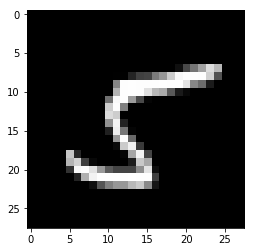

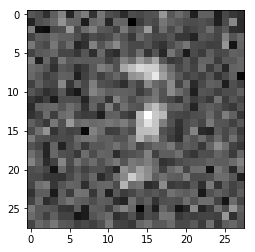

0 178.31784 178.31302 0.004821129


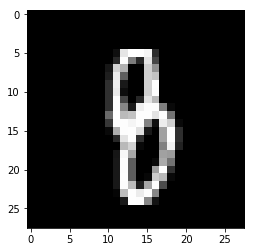

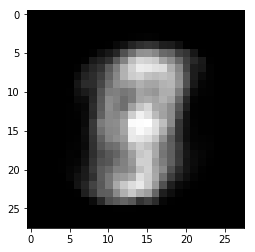

200 48.501637 46.843357 1.6582811


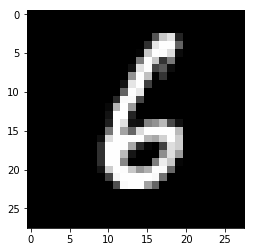

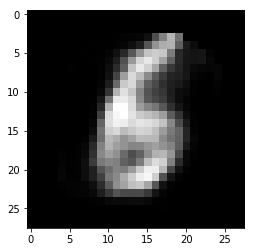

400 41.820553 36.184566 5.6359873


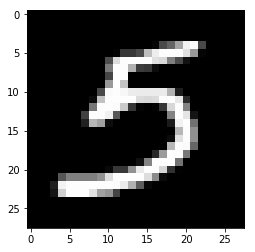

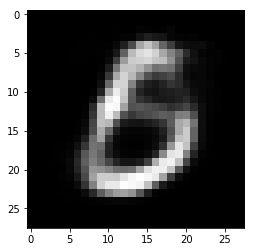

600 34.56848 27.02459 7.5438957


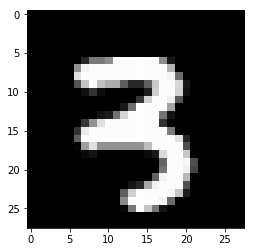

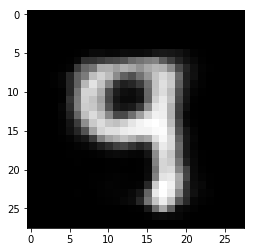

800 33.61699 25.869118 7.7478695


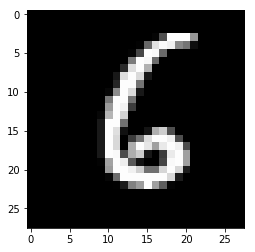

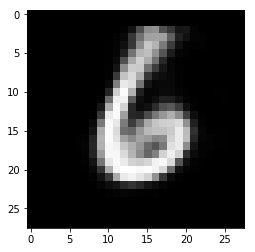

1000 34.00341 26.269253 7.7341576


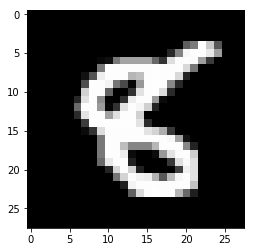

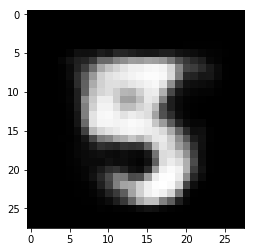

1200 34.70123 26.125113 8.576117


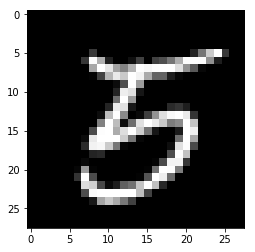

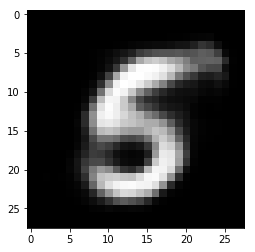

1400 30.559755 22.007248 8.552506


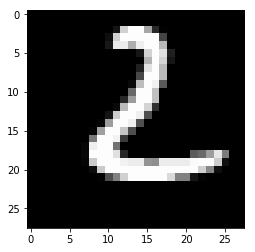

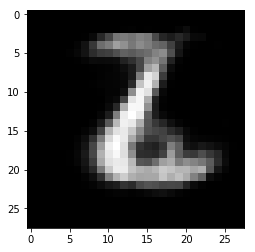

1600 31.08776 22.199535 8.888224


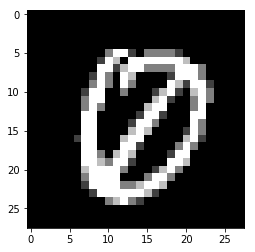

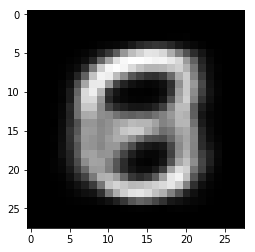

1800 31.31128 21.941795 9.369484


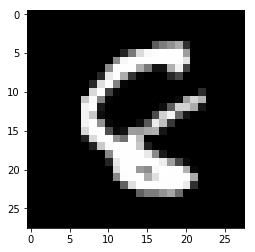

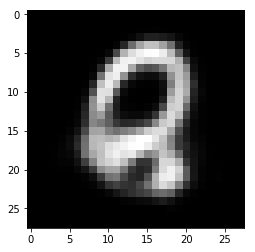

2000 31.868923 22.92834 8.940584


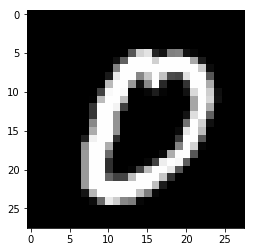

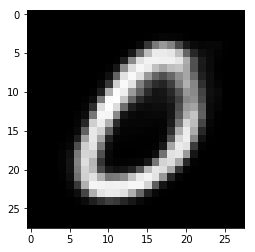

2200 30.02567 20.614597 9.41107


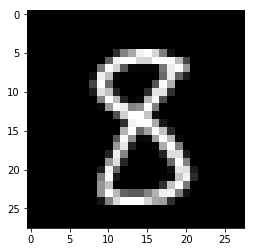

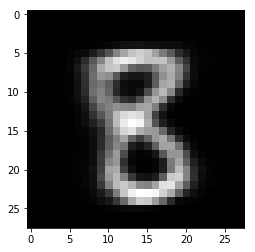

2400 30.106823 20.947632 9.159193


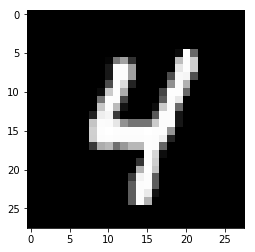

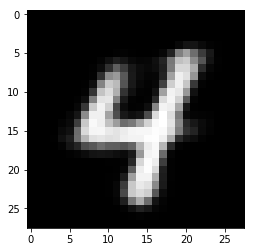

2600 29.161621 20.03239 9.129229


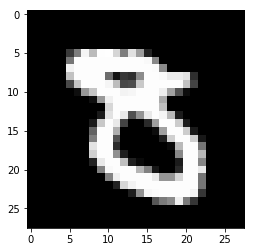

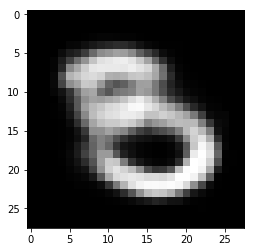

2800 30.295448 20.979082 9.316366


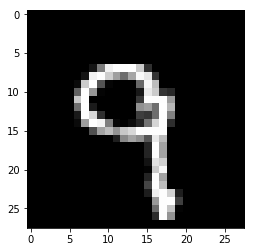

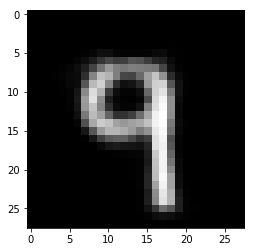

3000 29.036736 19.823444 9.213292


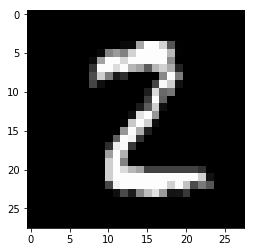

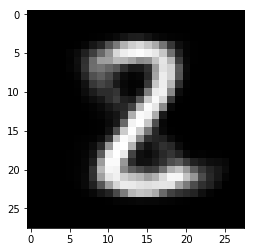

3200 29.468018 19.583227 9.88479


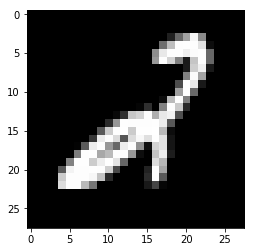

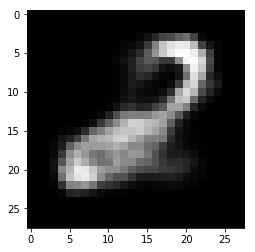

3400 31.312931 20.864998 10.447931


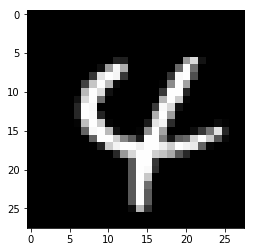

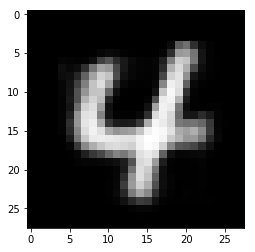

3600 30.660809 20.131403 10.529407


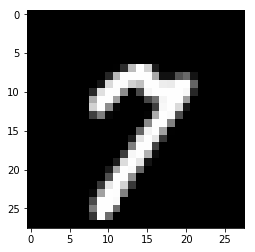

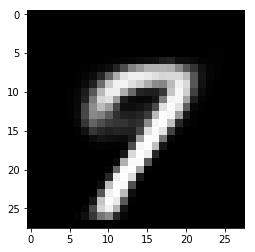

3800 30.624172 21.189571 9.434601


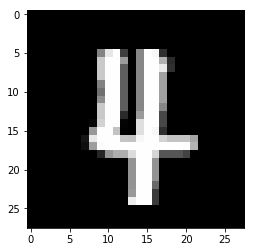

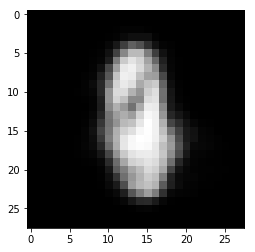

4000 28.968172 19.18774 9.780433


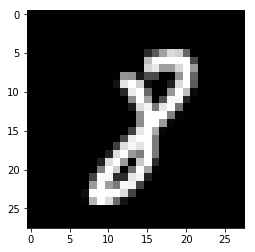

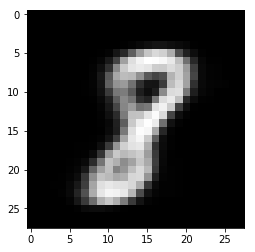

4200 28.903755 18.716417 10.187338


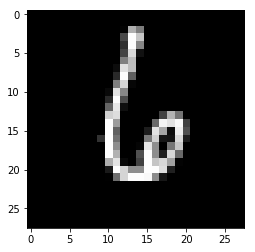

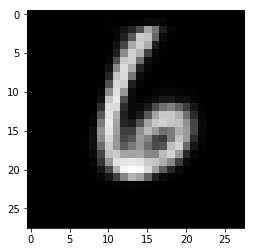

4400 31.586445 21.824608 9.761836


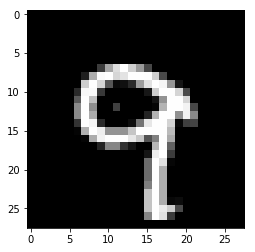

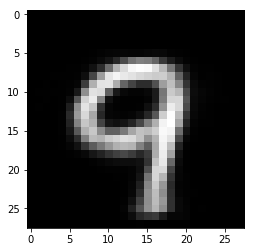

4600 28.990147 18.3418 10.648346


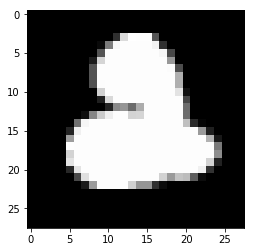

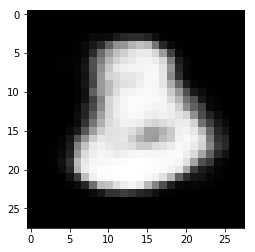

4800 27.415167 17.638283 9.776884


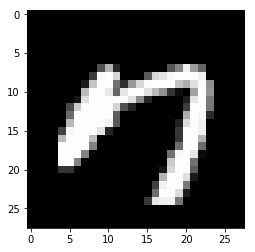

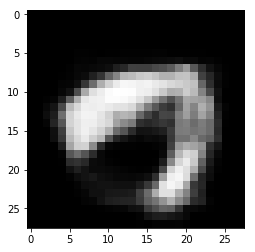

5000 31.487572 22.139149 9.348423


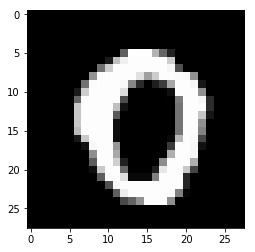

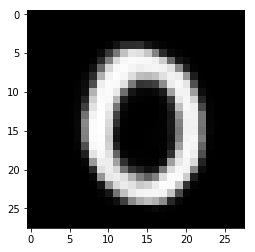

5200 27.99503 18.146032 9.848998


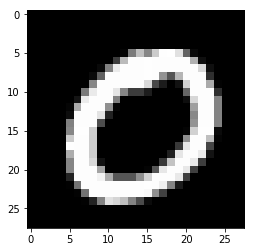

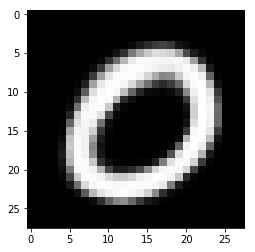

5400 28.308468 18.452091 9.856378


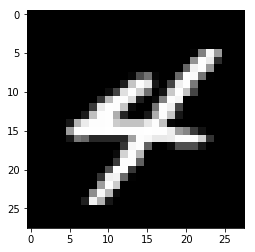

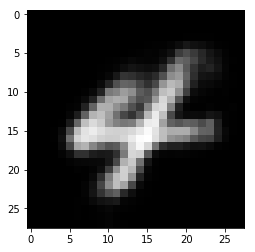

5600 28.349253 18.530281 9.81897


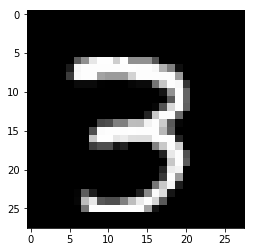

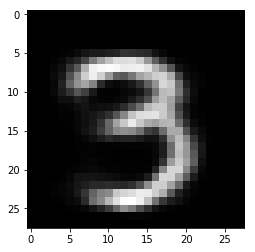

5800 30.769114 20.612732 10.156383


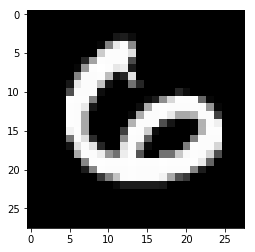

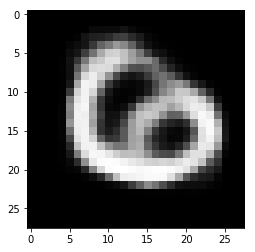

6000 28.401226 18.398397 10.002829


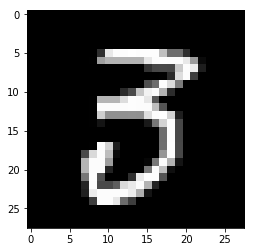

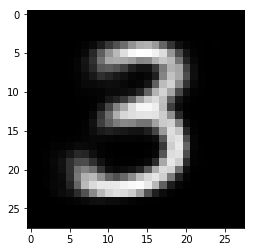

6200 28.257381 18.352964 9.904417


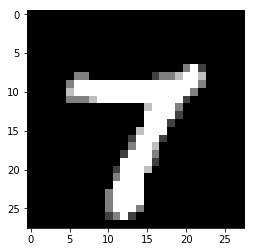

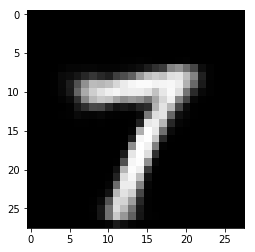

6400 28.501139 18.224703 10.276436


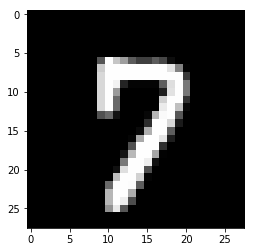

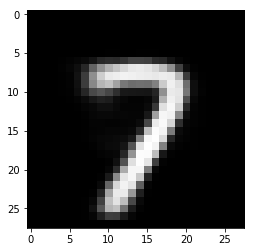

6600 29.271847 19.248745 10.023104


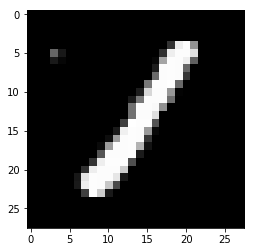

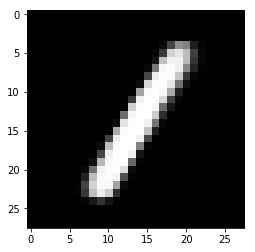

6800 27.285248 17.259369 10.025876


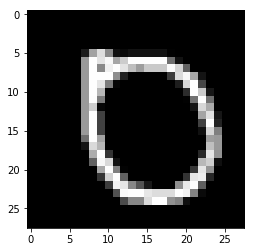

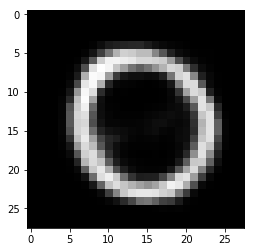

7000 30.04618 19.72524 10.32094


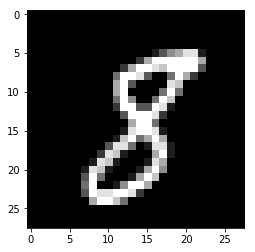

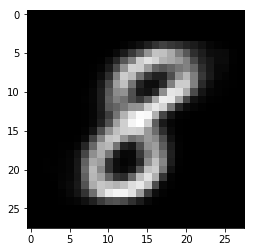

7200 32.464127 22.379333 10.084795


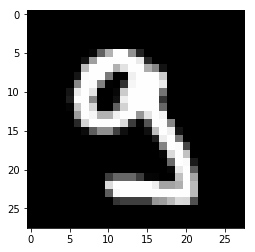

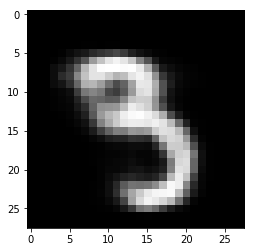

7400 28.42038 18.469166 9.951213


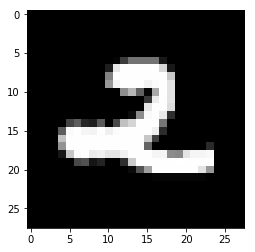

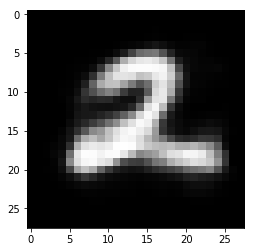

7600 29.944435 19.597809 10.346628


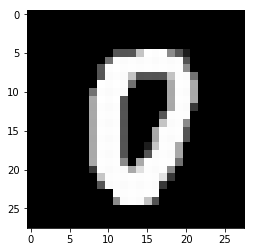

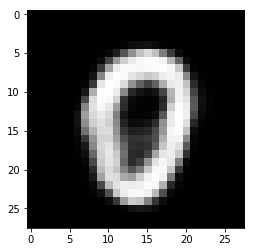

7800 28.012339 18.00938 10.00296


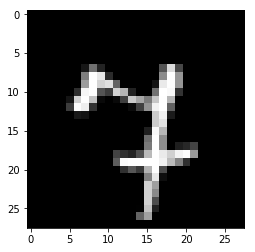

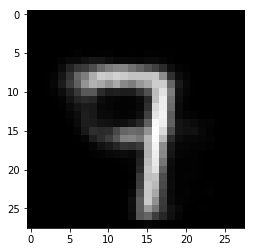

8000 28.660498 18.486488 10.174011


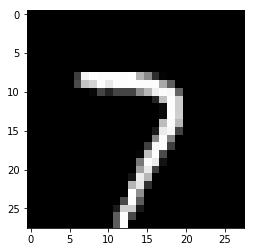

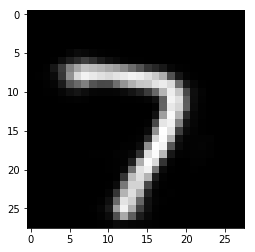

8200 27.943726 17.46643 10.477297


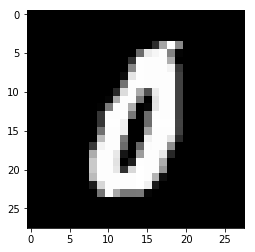

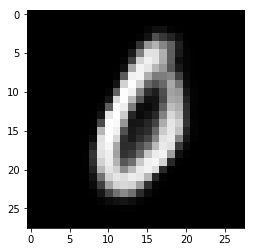

8400 29.178837 19.241264 9.937571


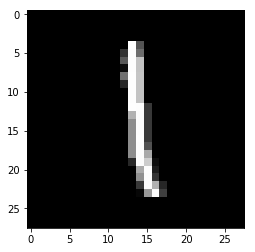

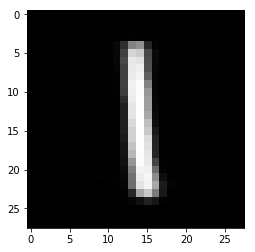

8600 29.665356 19.731644 9.933714


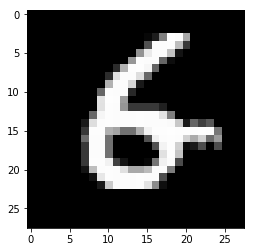

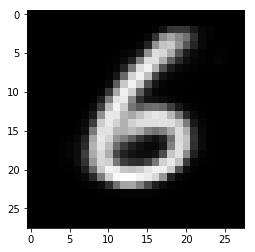

8800 28.848932 18.551815 10.297119


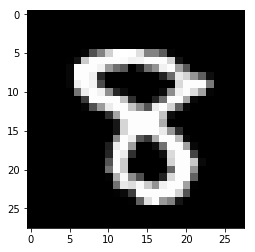

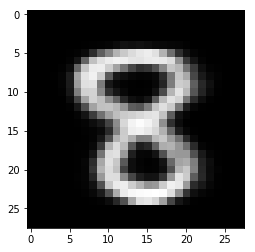

9000 29.146433 18.474873 10.67156


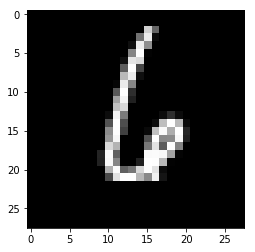

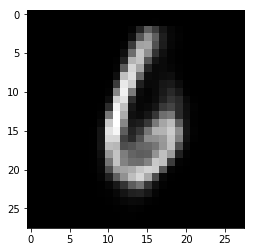

9200 28.000378 17.650349 10.350029


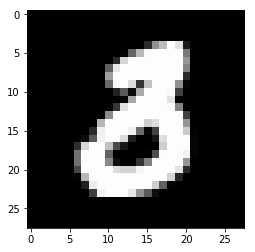

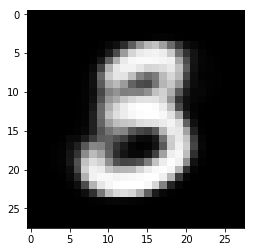

9400 28.316015 18.104408 10.211607


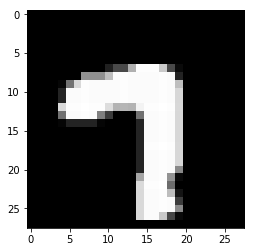

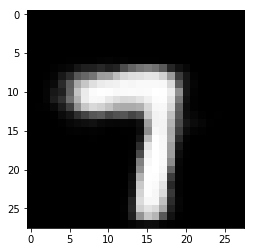

9600 25.907337 15.621739 10.285599


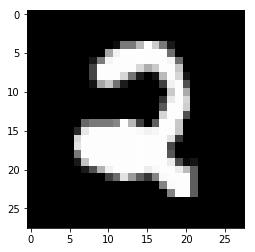

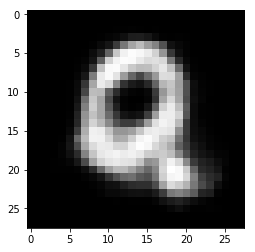

9800 25.052032 15.232048 9.819985


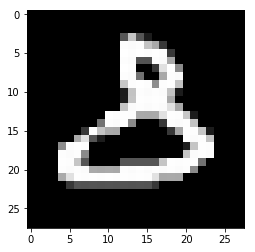

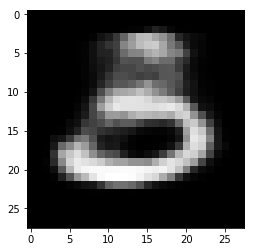

10000 29.824102 19.967533 9.856569


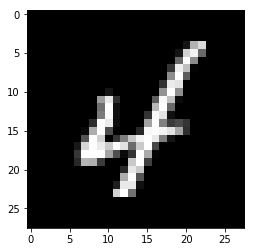

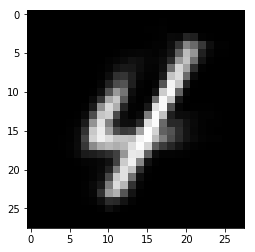

10200 29.375565 19.284924 10.090641


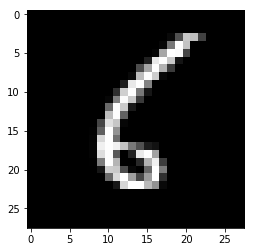

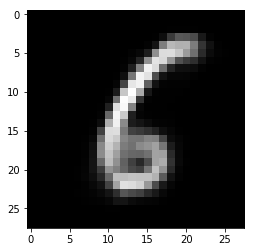

10400 28.436245 18.252674 10.183573


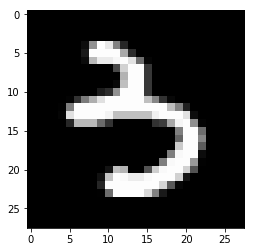

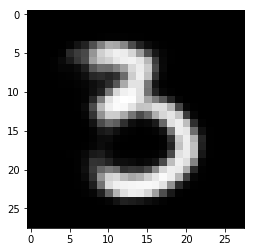

10600 27.937134 17.716085 10.22105


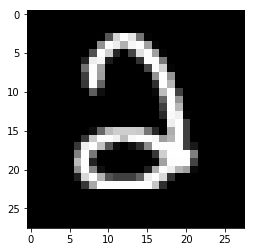

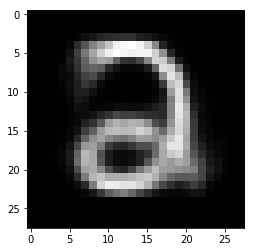

10800 30.255651 19.389893 10.865757


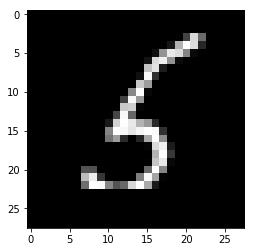

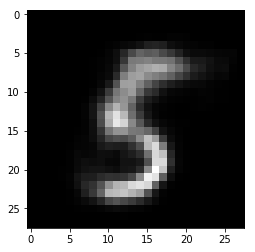

11000 30.678654 20.438354 10.240299


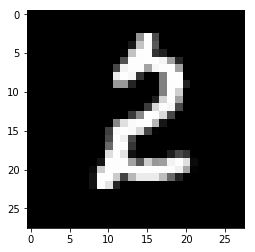

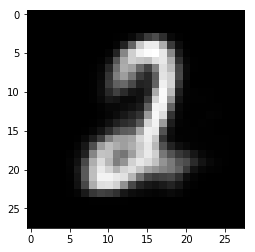

11200 26.77912 16.429491 10.349629


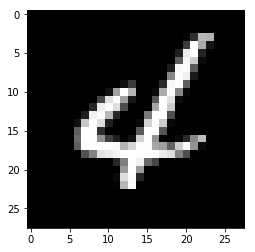

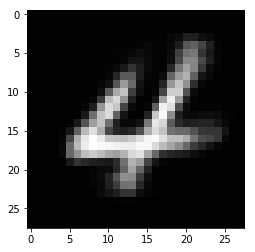

11400 27.740032 17.384062 10.35597


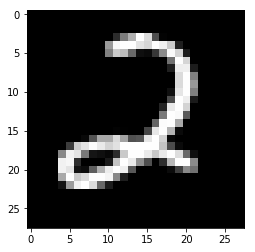

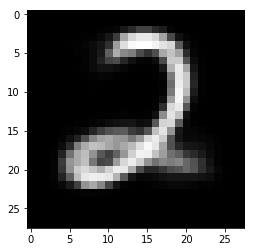

11600 29.28777 18.551685 10.736081


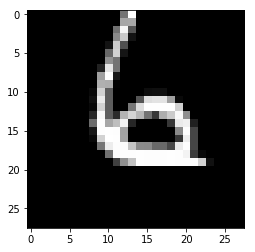

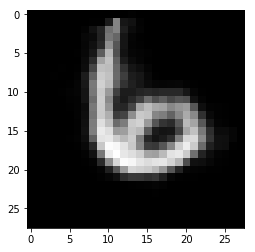

11800 27.98624 17.782146 10.204093


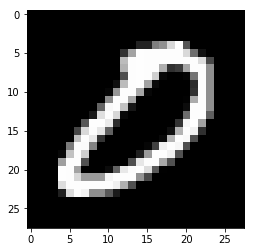

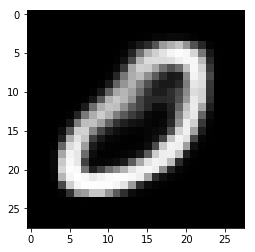

12000 28.18203 18.418451 9.763576


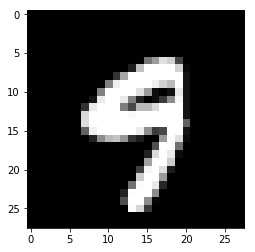

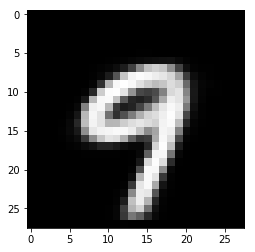

12200 29.522343 18.863543 10.6588


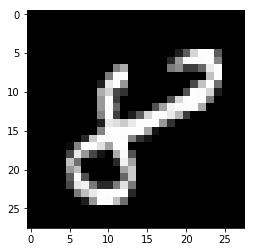

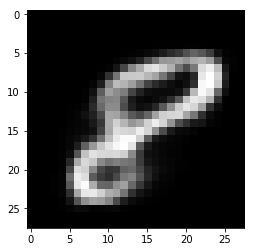

12400 29.58251 18.658169 10.92434


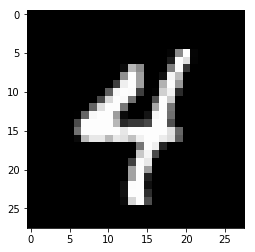

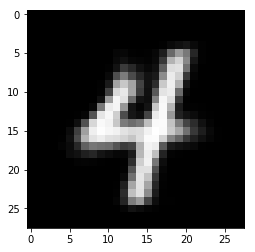

12600 25.755516 15.868118 9.887398


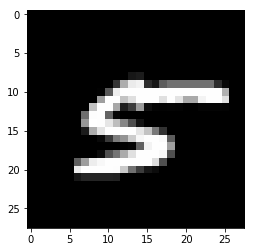

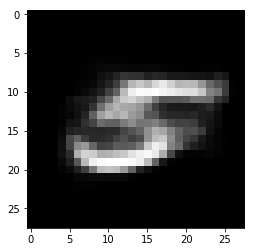

12800 26.720837 16.686918 10.03392


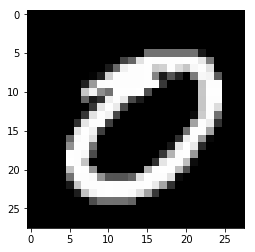

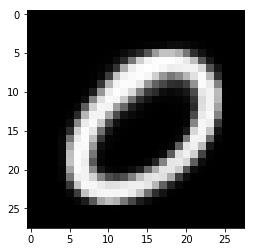

13000 29.47484 18.604826 10.870013


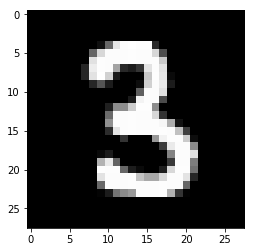

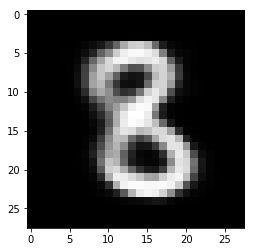

13200 28.295816 17.669157 10.626659


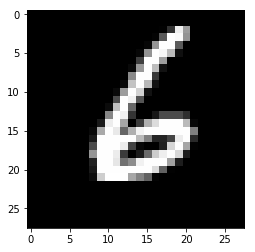

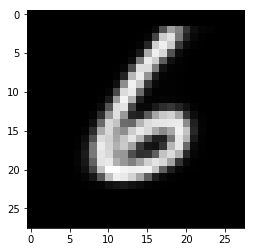

13400 30.983376 20.017956 10.96542


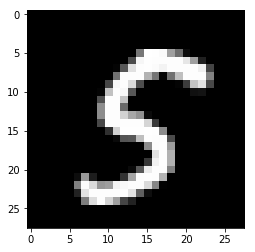

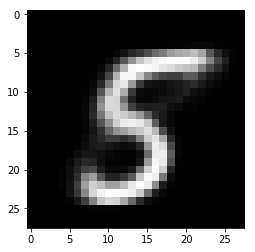

13600 29.0626 18.41764 10.6449585


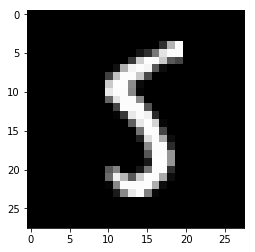

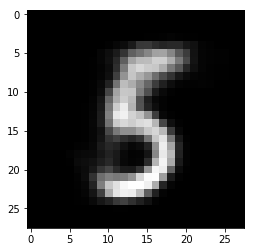

13800 27.394741 16.537172 10.857571


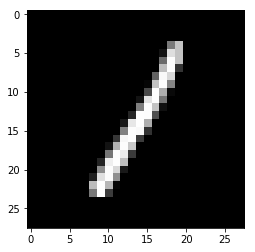

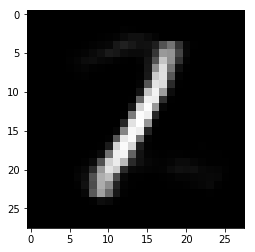

14000 27.288235 16.86082 10.427414


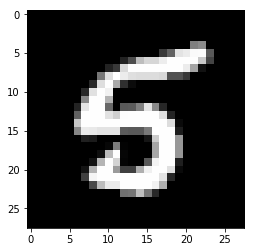

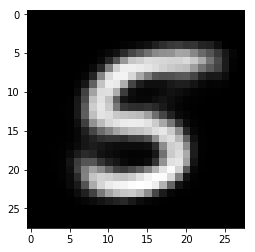

14200 27.12781 16.59916 10.528649


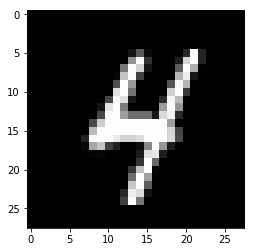

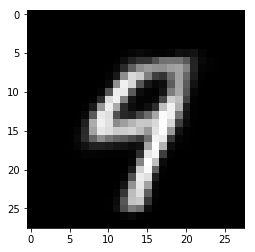

14400 28.40187 18.099064 10.302807


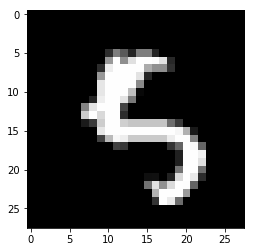

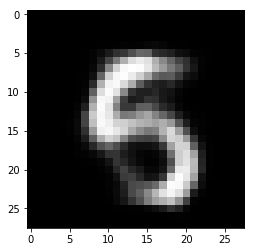

14600 27.618511 16.976727 10.641785


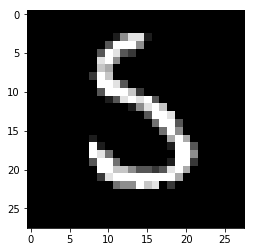

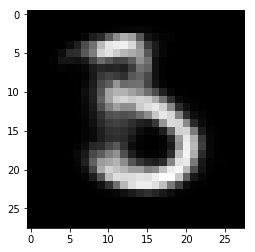

14800 27.226562 16.56563 10.660934


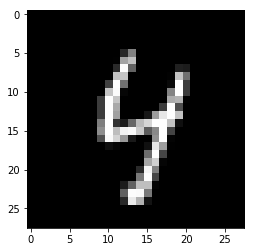

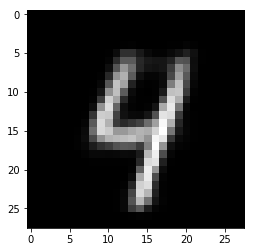

15000 26.018202 15.747056 10.271146


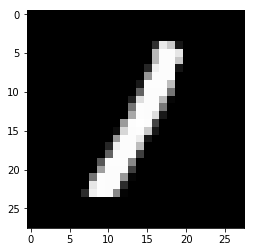

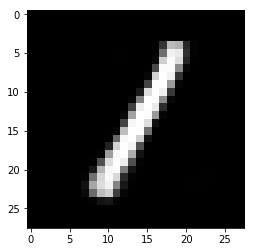

15200 29.62788 19.019485 10.608394


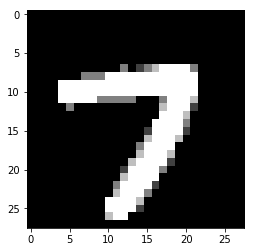

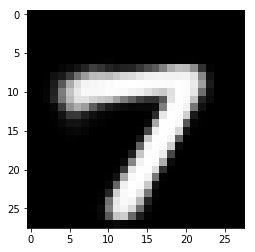

15400 28.434557 17.889322 10.545237


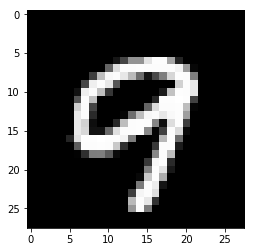

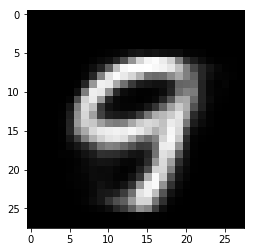

15600 27.81431 17.562744 10.251566


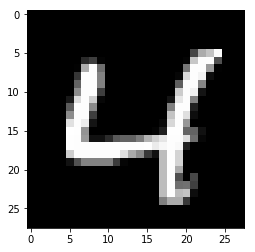

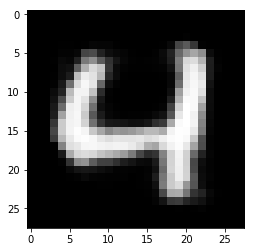

15800 27.707802 17.821173 9.886627


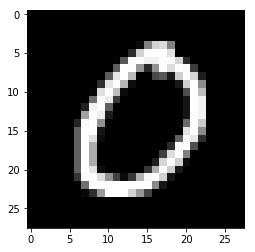

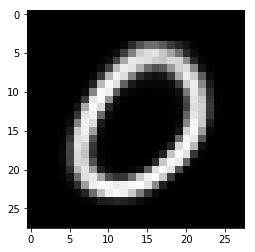

16000 28.57204 18.436419 10.135622


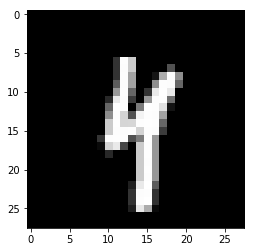

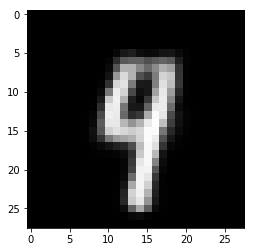

16200 28.559387 17.846525 10.71286


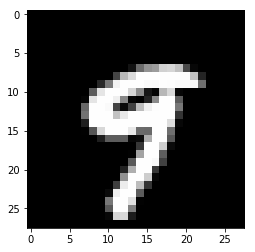

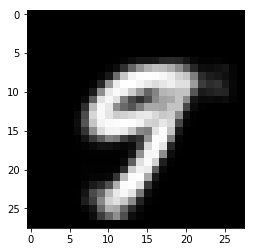

16400 28.482265 17.771023 10.711241


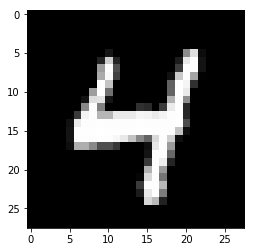

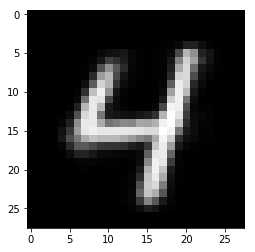

16600 26.840229 16.604185 10.236045


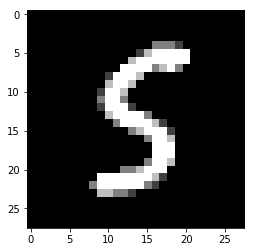

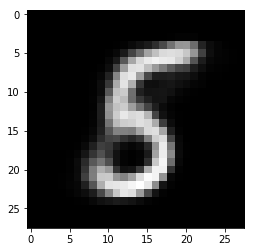

16800 27.003931 16.998348 10.005583


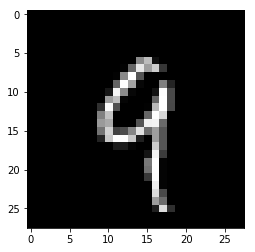

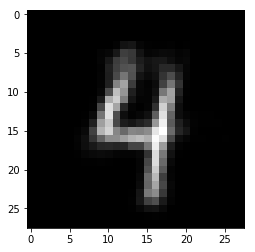

17000 29.033 18.544405 10.488596


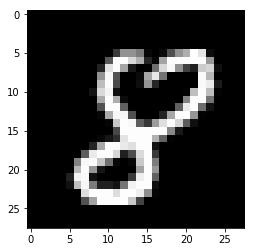

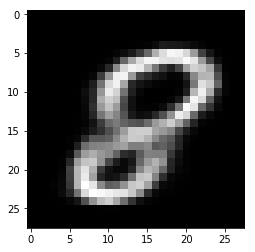

17200 27.389936 17.098396 10.29154


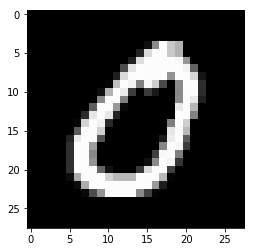

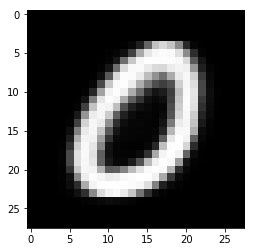

17400 26.78298 16.060177 10.722803


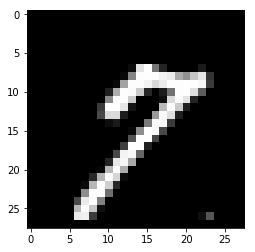

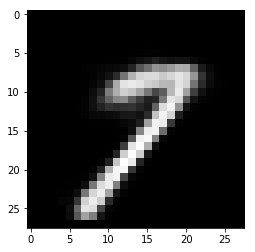

17600 26.25095 15.828617 10.422332


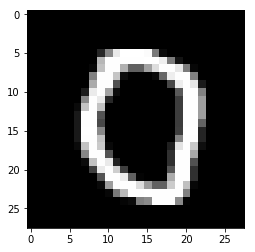

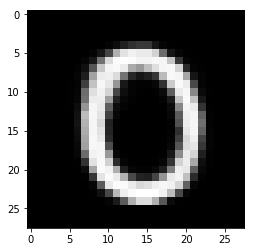

17800 29.898373 18.301285 11.597088


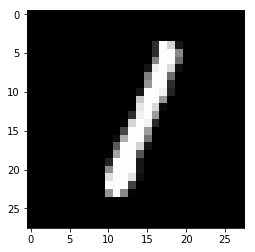

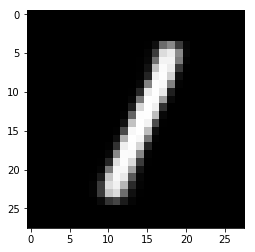

18000 27.603043 16.673832 10.929211


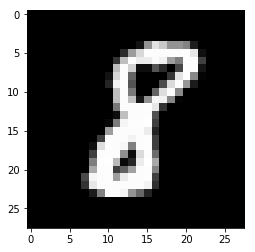

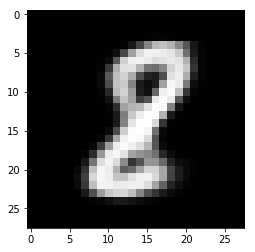

18200 26.40435 15.749328 10.655021


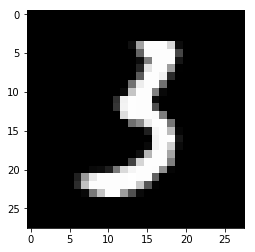

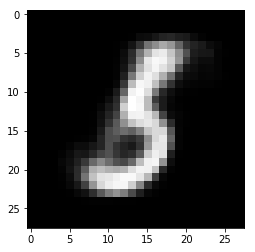

18400 26.207275 15.806818 10.400459


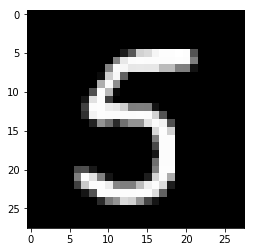

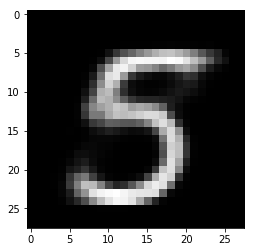

18600 27.98031 17.170181 10.810128


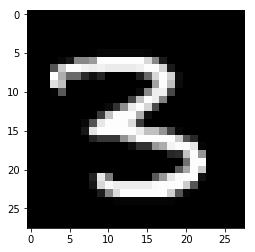

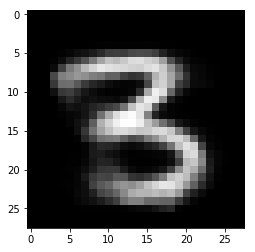

18800 27.497694 16.997734 10.499958


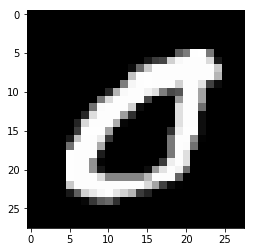

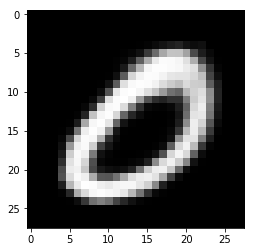

19000 28.400314 17.982246 10.418068


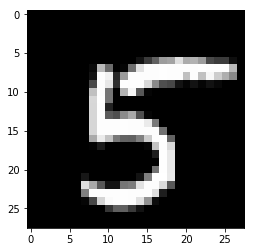

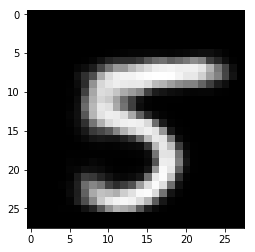

19200 27.82758 17.71655 10.111029


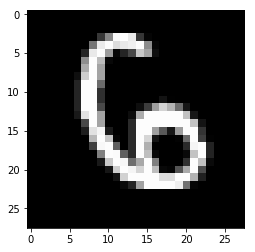

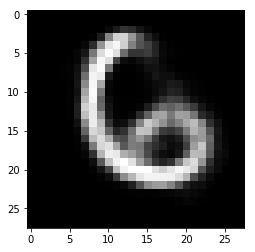

19400 27.601128 16.685883 10.915247


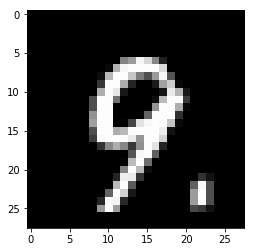

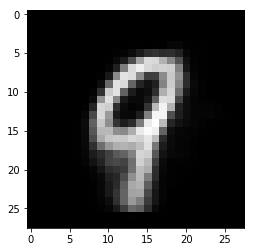

19600 27.468012 16.844547 10.623463


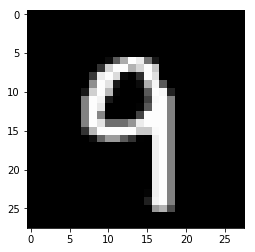

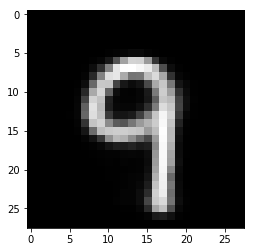

19800 28.593155 18.17817 10.414983


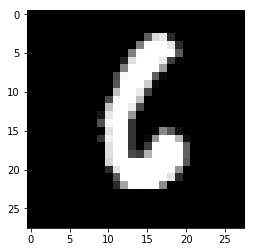

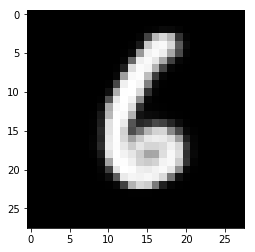

20000 26.327547 16.05058 10.27697


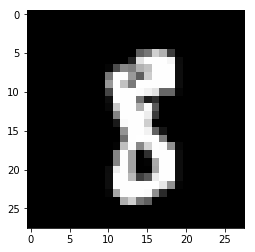

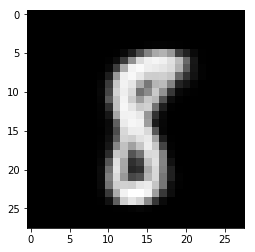

20200 26.755375 16.211115 10.54426


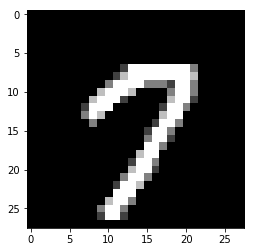

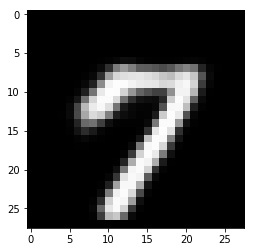

20400 28.810452 17.402777 11.407674


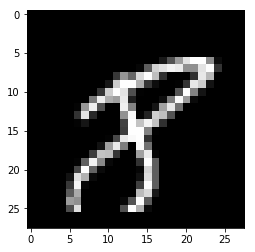

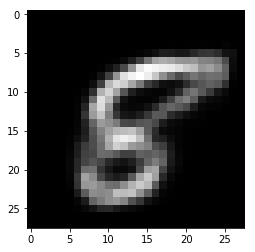

20600 27.037964 16.853096 10.184867


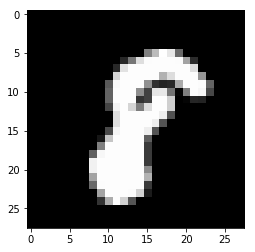

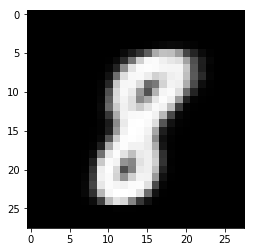

20800 27.45556 16.756416 10.699144


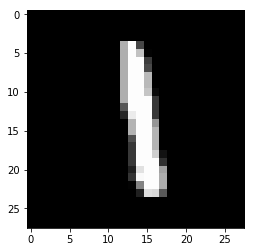

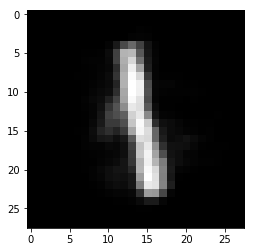

21000 26.58422 15.367025 11.2171955


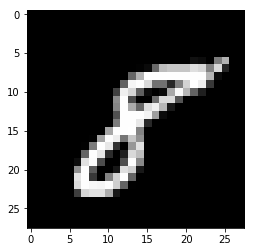

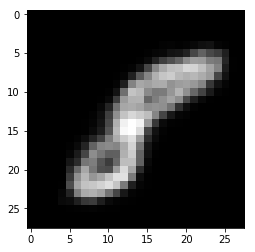

21200 28.213446 17.787159 10.426285


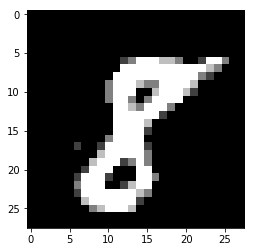

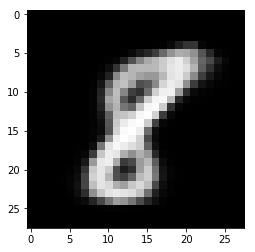

21400 26.234295 15.4879875 10.746305


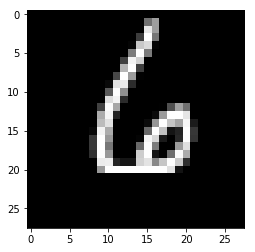

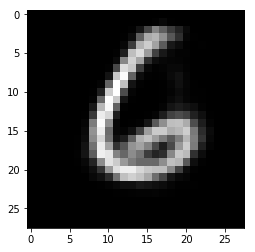

21600 27.632921 17.170742 10.462177


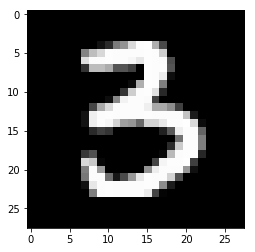

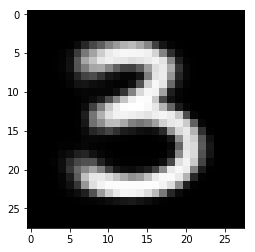

21800 27.011953 16.560822 10.451131


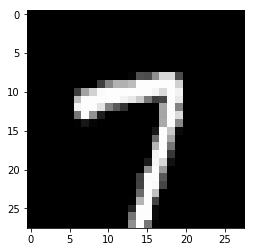

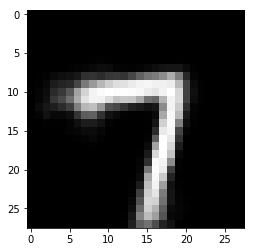

22000 25.432713 14.820713 10.612


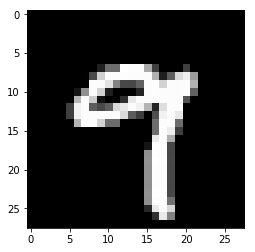

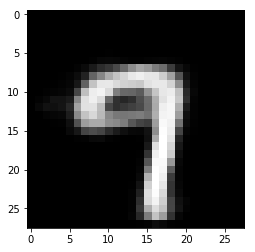

22200 28.019972 17.254822 10.765151


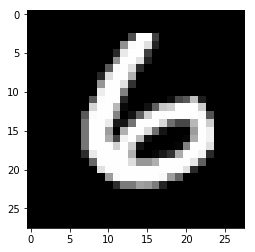

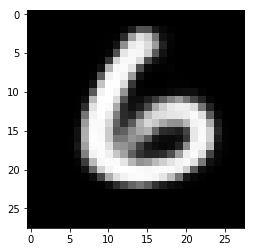

22400 27.238106 16.545387 10.692718


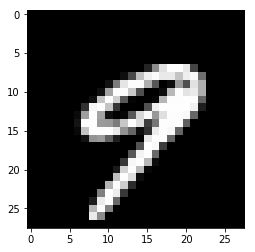

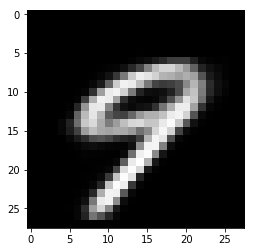

22600 25.706055 15.431852 10.274202


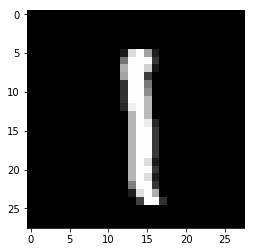

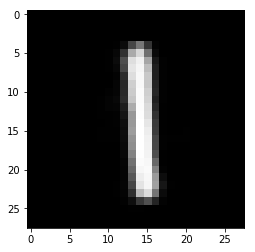

22800 29.60608 18.81739 10.78869


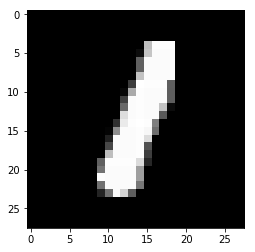

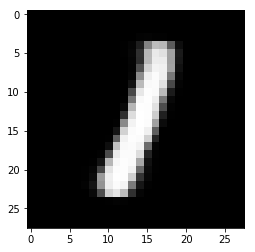

23000 26.159634 15.956611 10.203024


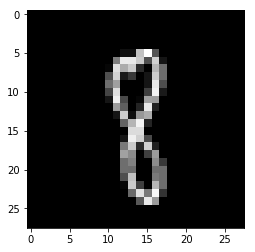

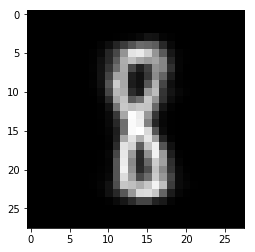

23200 25.717287 14.99962 10.717667


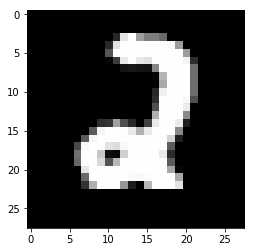

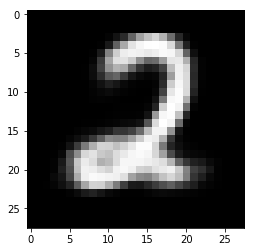

23400 27.285213 16.270859 11.014355


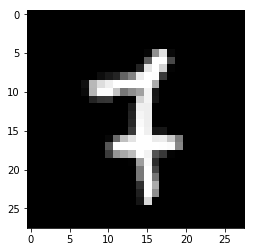

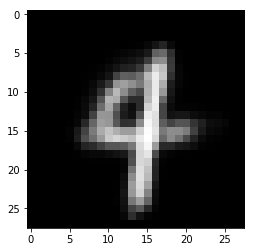

23600 26.453777 16.010113 10.443665


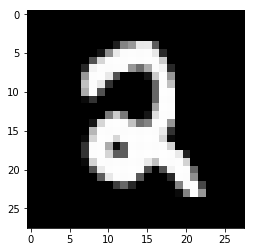

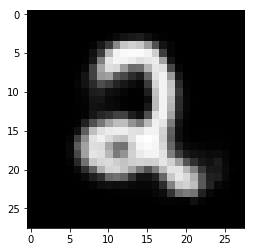

23800 26.582226 15.849696 10.732529


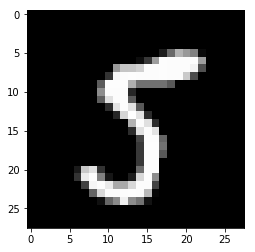

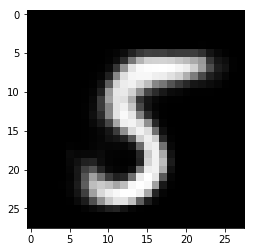

24000 27.361357 17.024216 10.337141


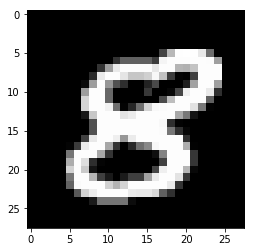

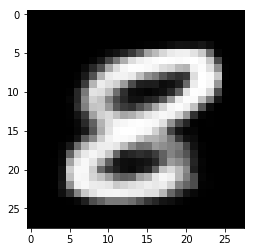

24200 26.940926 16.247295 10.693629


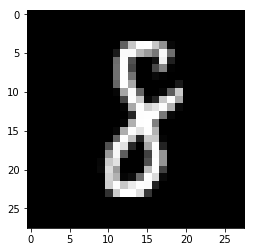

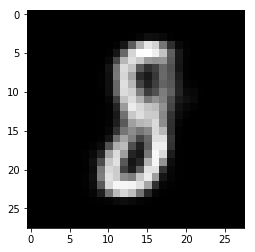

24400 27.699615 16.815863 10.883754


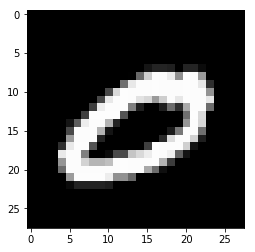

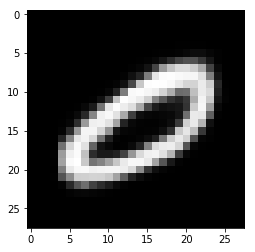

24600 25.888294 15.478025 10.410268


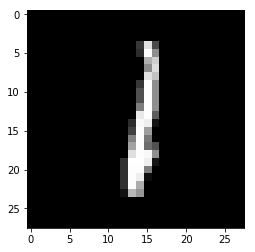

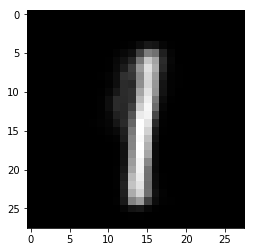

24800 27.53054 16.825264 10.705278


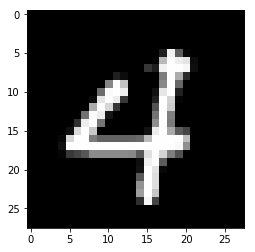

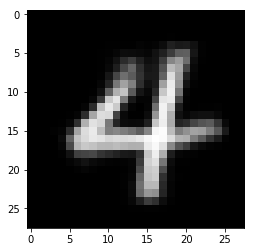

25000 25.437 15.147327 10.289673


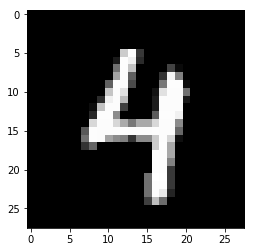

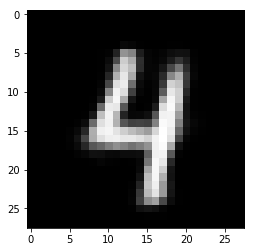

25200 26.012493 15.216325 10.796166


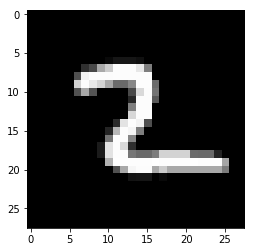

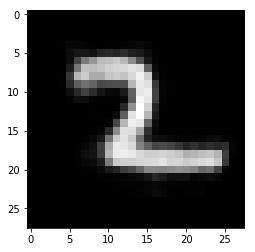

25400 28.092064 17.021713 11.070353


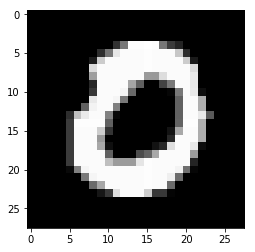

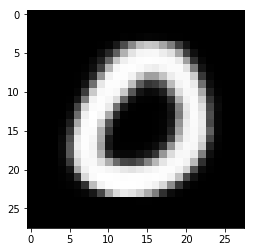

25600 26.736715 15.441748 11.294968


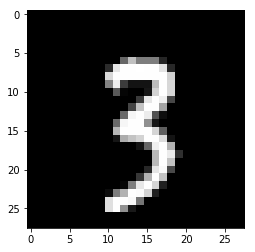

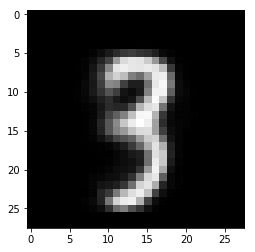

25800 26.170986 15.975601 10.195384


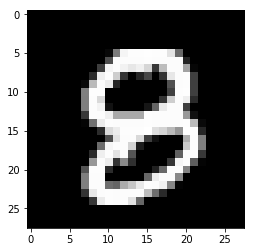

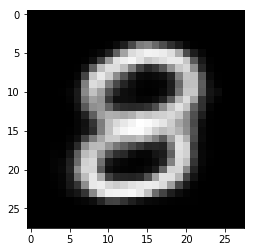

26000 26.607973 16.283852 10.324122


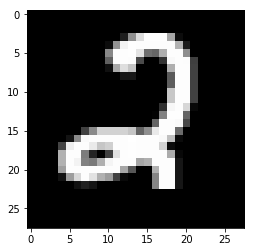

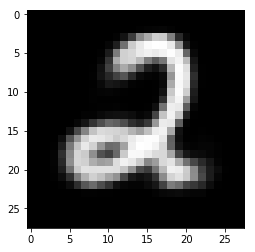

26200 26.589317 16.041182 10.548135


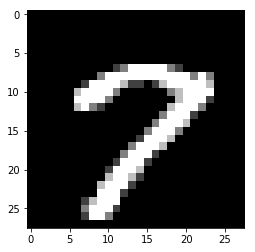

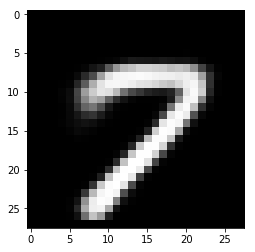

26400 26.86746 15.699663 11.167795


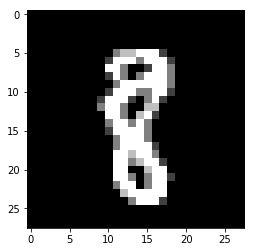

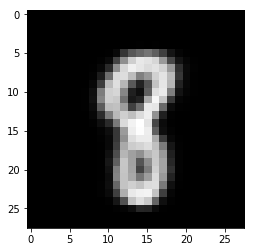

26600 28.453175 17.32078 11.132398


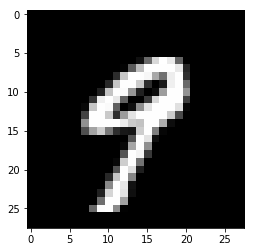

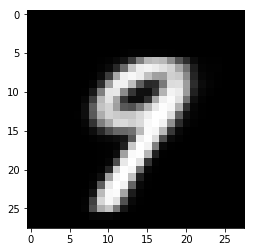

26800 26.262526 15.794863 10.467663


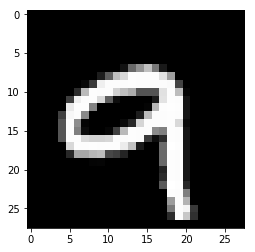

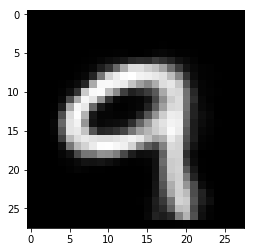

27000 26.403776 15.76321 10.640566


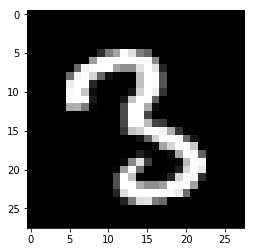

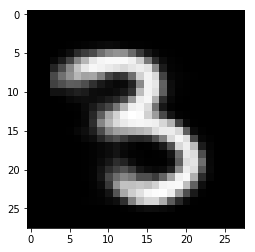

27200 27.360931 16.802471 10.558458


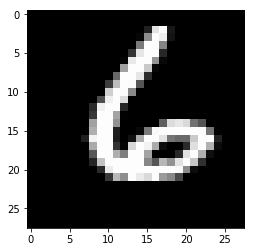

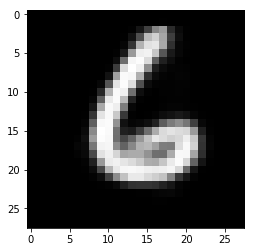

27400 27.41293 16.77795 10.634979


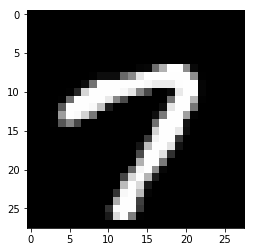

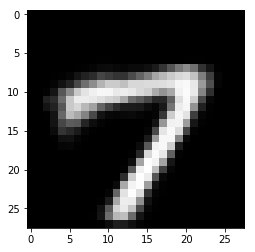

27600 27.013016 16.418835 10.594179


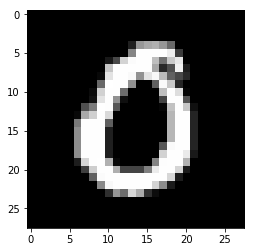

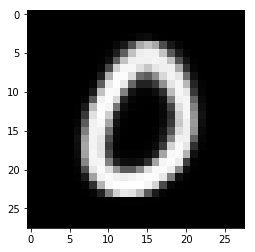

27800 25.906504 15.37117 10.535334


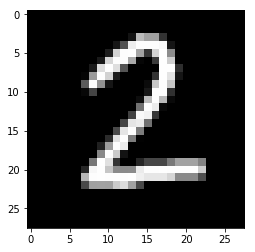

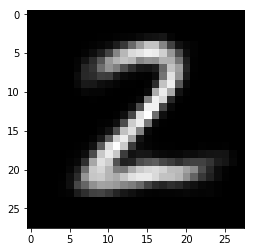

28000 28.304138 17.282234 11.021902


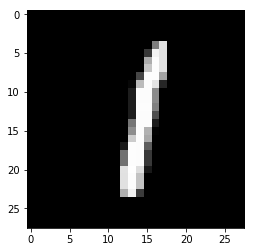

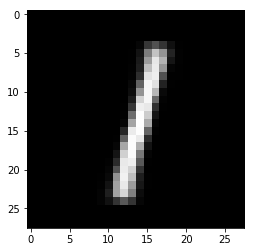

28200 27.295128 16.396212 10.898916


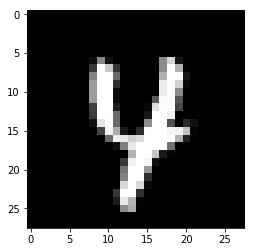

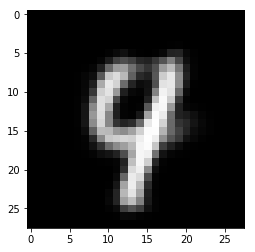

28400 29.233166 17.909386 11.323781


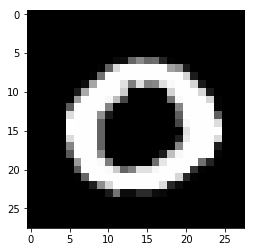

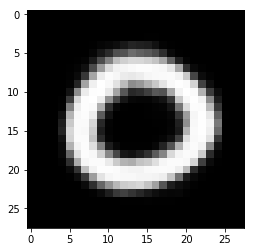

28600 28.242626 17.43612 10.806507


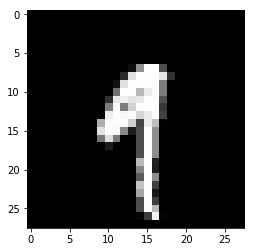

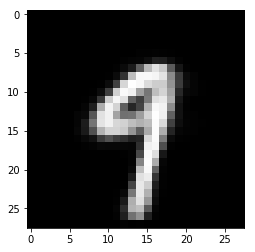

28800 24.566303 14.338089 10.228214


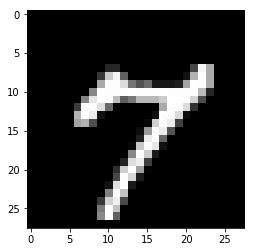

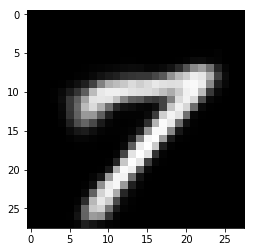

29000 27.979832 17.10823 10.871601


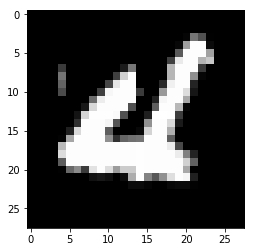

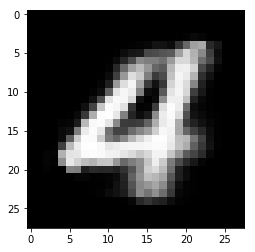

29200 25.525333 14.80381 10.721525


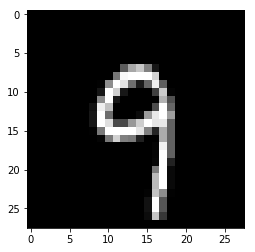

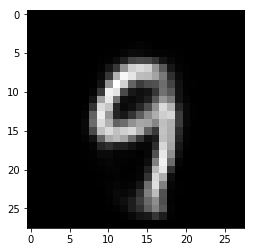

29400 27.575462 16.363972 11.21149


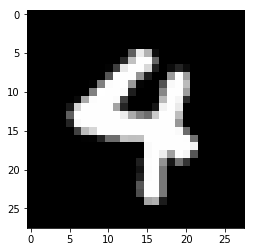

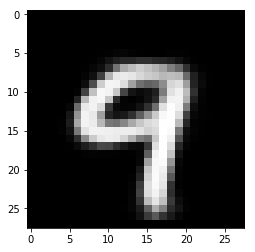

29600 26.424648 15.3861065 11.038542


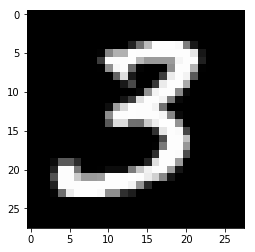

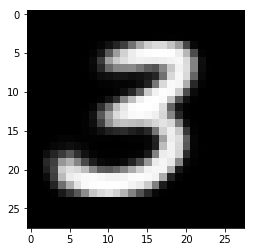

29800 26.565395 15.41761 11.147784


In [74]:
# training
rounds = 200 # should be over 30000 for good result
for i in range(rounds):
    batch = [np.reshape(b, [28, 28]) for b in mnist.train.next_batch(batch_size=batch_size)[0]]
    sess.run(optimizer, feed_dict = {X_in: batch, Y: batch, keep_prob: 0.8})
        
    if not i % 100:
        ls, d, i_ls, d_ls, mu, sigm = sess.run([loss, dec, img_loss, latent_loss, mn, sd], feed_dict = {X_in: batch, Y: batch, keep_prob: 1.0})
        plt.imshow(np.reshape(batch[0], [28, 28]), cmap='gray')
        plt.show()
        plt.imshow(d[0], cmap='gray')
        plt.show()
        print(i, ls, np.mean(i_ls), np.mean(d_ls))

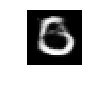

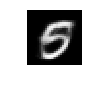

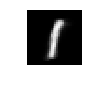

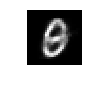

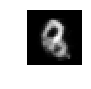

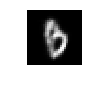

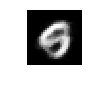

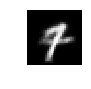

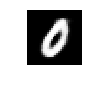

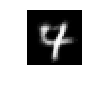

In [75]:
randoms = [np.random.normal(0, 1, n_latent) for _ in range(10)]
imgs = sess.run(dec, feed_dict = {sampled: randoms, keep_prob: 1.0})
imgs = [np.reshape(imgs[i], [28, 28]) for i in range(len(imgs))]

for img in imgs:
    plt.figure(figsize=(1,1))
    plt.axis('off')
    plt.imshow(img, cmap='gray')